In [1]:
import torch
from torch import nn, optim
from torchsummary import summary
from torchvision.utils import make_grid
import os
from shutil import rmtree
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def pil_to_np_array(pil_image):
    array = np.array(pil_image).transpose(2,0,1)
    return array.astype(np.float32) / 255.

def np_to_torch_array(np_array):
    return torch.from_numpy(np_array)[None, :]

def torch_to_np_array(torch_array):
    return torch_array.detach().cpu().numpy()[0]

def read_image(path, image_size = -1):
    pil_image = Image.open(path)
    return pil_image

def save_image(np_array, step):
    pil_image = Image.fromarray((np_array * 255.0).transpose(1, 2, 0).astype('uint8'), 'RGB')
    pil_image.save(f'progress/{str(step).zfill(len(str(TRAINING_STEPS)))}.png')

def get_image_grid(images, nrow = 3):
    torch_images = [torch.from_numpy(x) for x in images]
    grid = make_grid(torch_images, nrow)
    return grid.numpy()

def visualize_sample(*images_np, nrow = 3, size_factor = 10):
    c = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == c) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize = (len(images_np) + size_factor, 12 + size_factor))
    plt.axis('off')
    plt.imshow(grid.transpose(1, 2, 0))
    plt.show()

def calculate_psnr(original, watermarked):
    # Ensure the images have the same shape and data type
    mse = np.mean((original - watermarked) ** 2)
    if mse == 0:
        return float("inf")  # If images are identical
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [3]:
DTYPE = torch.cuda.FloatTensor
INPUT_DEPTH = 32
LR = 0.01
TRAINING_STEPS = 10000
SHOW_STEP = 1000
REG_NOISE = 0.03
MAX_DIM = 128

In [4]:
import gdown
file_id = '1hGLkDCDw5BrBnlO2RRwb6-2q2az6xYw_'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'image1.png'
gdown.download(url, output, quiet=False)

file_id = '12v_rSS1xR9QMyhaTwKgC9mDVK54DThks'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'watermark.png'
gdown.download(url, output, quiet=False)

original_image_path = 'image1.png'
watermark_path = 'watermark.png'

#original_image_path = os.path.join('/content/drive/My Drive/Dataset/image1.png')
#watermark_path = os.path.join('/content/drive/My Drive/Dataset/watermark.png')

original_image_pil = read_image(original_image_path)
original_image_pil = original_image_pil.convert('RGB')
original_image_pil = original_image_pil.resize((128, 128))

Downloading...
From: https://drive.google.com/uc?id=1hGLkDCDw5BrBnlO2RRwb6-2q2az6xYw_
To: /content/image1.png
100%|██████████| 165k/165k [00:00<00:00, 67.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=12v_rSS1xR9QMyhaTwKgC9mDVK54DThks
To: /content/watermark.png
100%|██████████| 2.72k/2.72k [00:00<00:00, 1.87MB/s]


In [5]:
w, h = original_image_pil.size
aspect_ratio = w / h
if w > MAX_DIM and w > h:
    h = int((h / w) * MAX_DIM)
    w = MAX_DIM
elif h > MAX_DIM and h > w:
    w = int((w / h) * MAX_DIM)
    h = MAX_DIM

original_image_pil = original_image_pil.resize((w, h))

watermark_pil = read_image(watermark_path)
watermark_pil = watermark_pil.convert('RGB')
watermark_pil = watermark_pil.resize((original_image_pil.size[0], original_image_pil.size[1]))

original_image_np = pil_to_np_array(original_image_pil)
watermark_np = pil_to_np_array(watermark_pil)

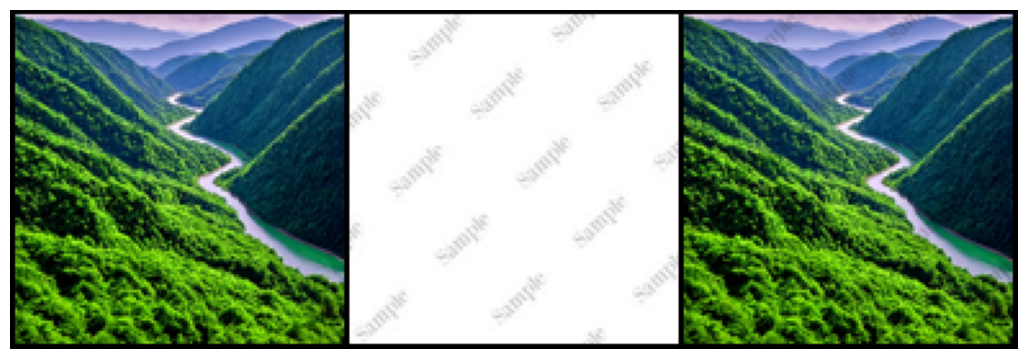

PSNR between the original and watermarked image: 85.47 dB


In [6]:
watermarked_np = original_image_np * watermark_np
image_mask_var = np_to_torch_array(watermark_np).type(DTYPE)

visualize_sample(original_image_np, watermark_np, watermarked_np, nrow = 3, size_factor = 10)
psnr_value = calculate_psnr(original_image_np, watermarked_np)
print(f"PSNR between the original and watermarked image: {psnr_value:.2f} dB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.3 MB/s eta 0:00:00


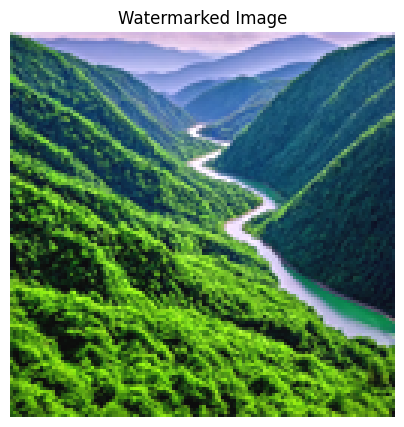

In [7]:
!pip install PyWavelets
import pywt

def embed_dwt_watermark(original_image_pil, watermark_path, alpha=0.1):
    original_image_np = np.array(original_image_pil)
    watermark_pil = Image.open(watermark_path).convert("L")
    watermark_resized = watermark_pil.resize((original_image_np.shape[1], original_image_np.shape[0]))
    watermark_np = np.array(watermark_resized)
    channels = [original_image_np[..., i] for i in range(3)]
    modified_channels = []

    for channel in channels:
        coeffs_image = pywt.dwt2(channel, "haar")
        LL, (LH, HL, HH) = coeffs_image
        watermark_LL = np.array(Image.fromarray(watermark_np).resize((LL.shape[1], LL.shape[0])))
        LL_modified = LL + alpha * watermark_LL
        modified_channel = pywt.idwt2((LL_modified, (LH, HL, HH)), "haar")
        modified_channel = np.clip(modified_channel, 0, 255).astype(np.uint8)
        modified_channels.append(modified_channel)

    watermarked_image_np = np.stack(modified_channels, axis=-1)

    return watermarked_image_np

watermarked_image_np = embed_dwt_watermark(original_image_pil, watermark_path, alpha=0.1)
watermarked_image_pil = Image.fromarray(watermarked_image_np)
plt.figure(figsize=(5, 5))
plt.imshow(watermarked_image_pil)
plt.title("Watermarked Image")
plt.axis("off")
plt.show()

In [8]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, bias = False):
        super(Conv2dBlock, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(int((kernel_size - 1) / 2)),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding = 0, bias = bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.model(x)

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

In [9]:
class SkipEncoderDecoder(nn.Module):
    def __init__(self, input_depth, num_channels_down = [128] * 5, num_channels_up = [128] * 5, num_channels_skip = [128] * 5):
        super(SkipEncoderDecoder, self).__init__()

        self.model = nn.Sequential()
        model_tmp = self.model

        for i in range(len(num_channels_down)):

            deeper = nn.Sequential()
            skip = nn.Sequential()

            if num_channels_skip[i] != 0:
                model_tmp.add_module(str(len(model_tmp) + 1), Concat(1, skip, deeper))
            else:
                model_tmp.add_module(str(len(model_tmp) + 1), deeper)

            model_tmp.add_module(str(len(model_tmp) + 1), nn.BatchNorm2d(num_channels_skip[i] + (num_channels_up[i + 1] if i < (len(num_channels_down) - 1) else num_channels_down[i])))

            if num_channels_skip[i] != 0:
                skip.add_module(str(len(skip) + 1), Conv2dBlock(input_depth, num_channels_skip[i], 1, bias = False))

            deeper.add_module(str(len(deeper) + 1), Conv2dBlock(input_depth, num_channels_down[i], 3, 2, bias = False))
            deeper.add_module(str(len(deeper) + 1), Conv2dBlock(num_channels_down[i], num_channels_down[i], 3, bias = False))

            deeper_main = nn.Sequential()

            if i == len(num_channels_down) - 1:
                k = num_channels_down[i]
            else:
                deeper.add_module(str(len(deeper) + 1), deeper_main)
                k = num_channels_up[i + 1]

            deeper.add_module(str(len(deeper) + 1), nn.Upsample(scale_factor = 2, mode = 'nearest'))

            model_tmp.add_module(str(len(model_tmp) + 1), Conv2dBlock(num_channels_skip[i] + k, num_channels_up[i], 3, 1, bias = False))
            model_tmp.add_module(str(len(model_tmp) + 1), Conv2dBlock(num_channels_up[i], num_channels_up[i], 1, bias = False))

            input_depth = num_channels_down[i]
            model_tmp = deeper_main

        self.model.add_module(str(len(self.model) + 1), nn.Conv2d(num_channels_up[0], 3, 1, bias = True))
        self.model.add_module(str(len(self.model) + 1), nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

def input_noise(input_depth, spatial_size, scale = 1.0/10):
    shape = [1, input_depth, spatial_size[0], spatial_size[1]]
    return torch.rand(*shape) * scale

In [10]:
generator = SkipEncoderDecoder(
    INPUT_DEPTH,
    num_channels_down = [128] * 5,
    num_channels_up = [128] * 5,
    num_channels_skip = [128] * 5
).type(DTYPE)
generator_input = input_noise(INPUT_DEPTH, watermarked_np.shape[1:]).type(DTYPE)
# summary(generator, generator_input.shape[1:])

objective = torch.nn.MSELoss().type(DTYPE)
optimizer = optim.Adam(generator.parameters(), LR)

watermarked_var = np_to_torch_array(watermarked_np).type(DTYPE)
watermark_var = np_to_torch_array(watermark_np).type(DTYPE)

generator_input_saved = generator_input.detach().clone()
noise = generator_input.detach().clone()

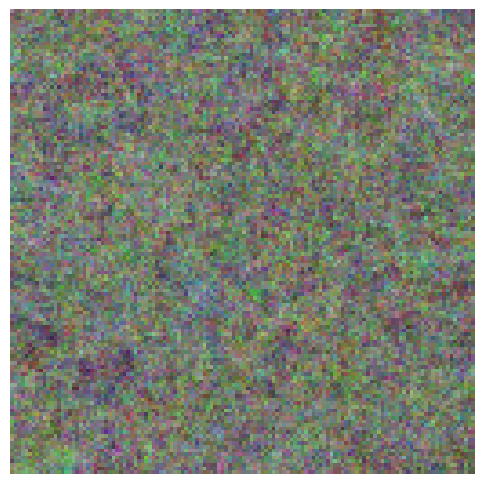

Step: 0 | Loss: 0.08743363618850708


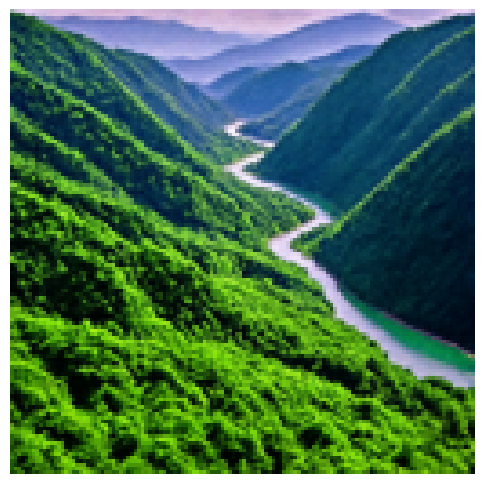

Step: 1000 | Loss: 0.0006193816661834717


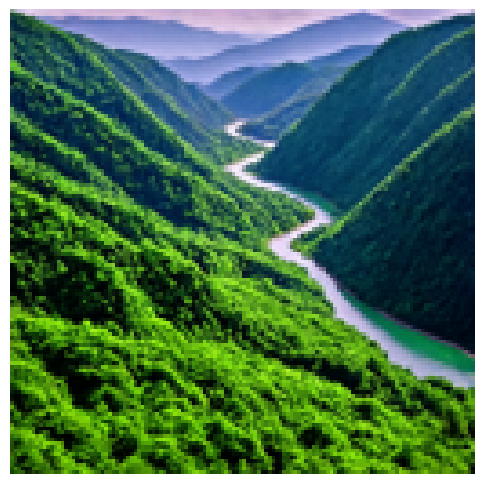

Step: 2000 | Loss: 0.00025398965226486325


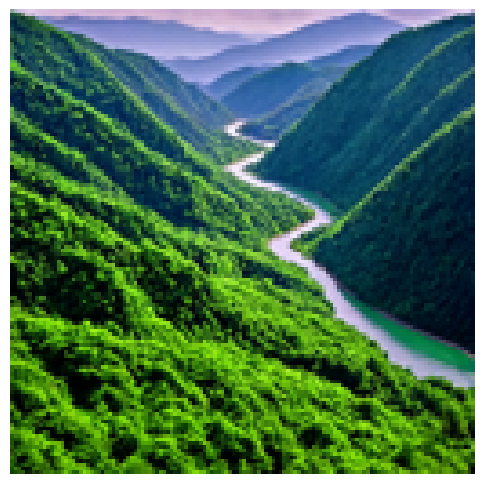

Step: 3000 | Loss: 0.0001766532368492335


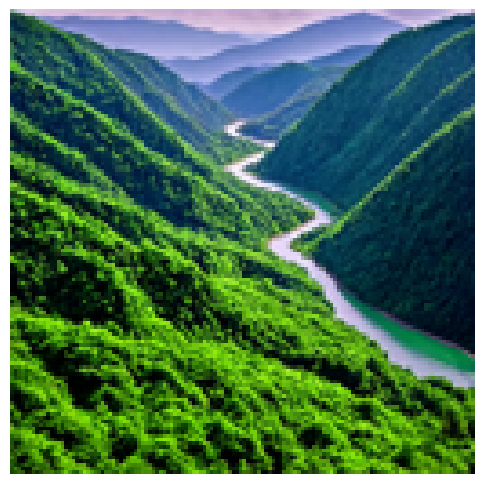

Step: 4000 | Loss: 0.00014111360360402614


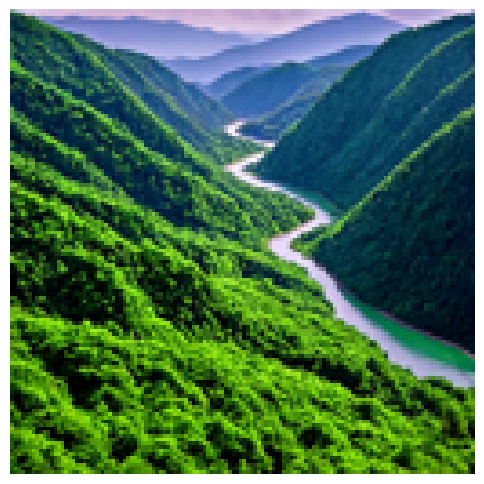

Step: 5000 | Loss: 5.2954645070713013e-05


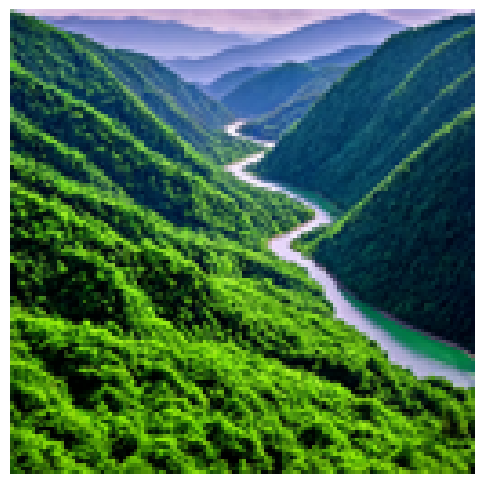

Step: 6000 | Loss: 2.6848214474739507e-05


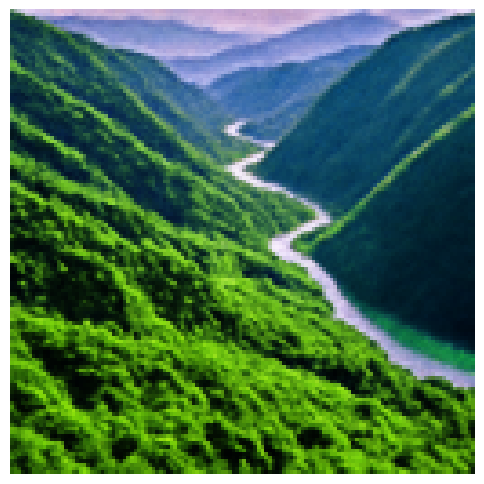

Step: 7000 | Loss: 0.002262893132865429


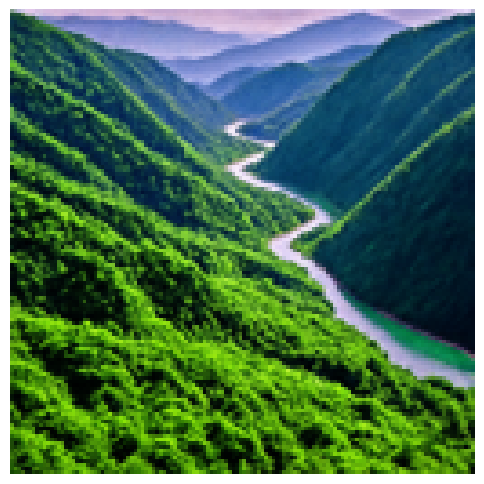

Step: 8000 | Loss: 0.0005330586573109031


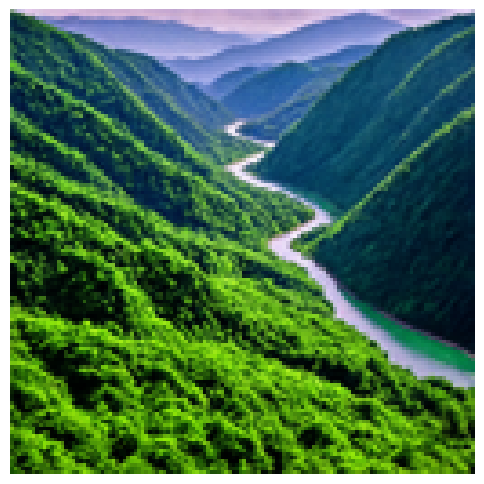

Step: 9000 | Loss: 0.00029227763297967613


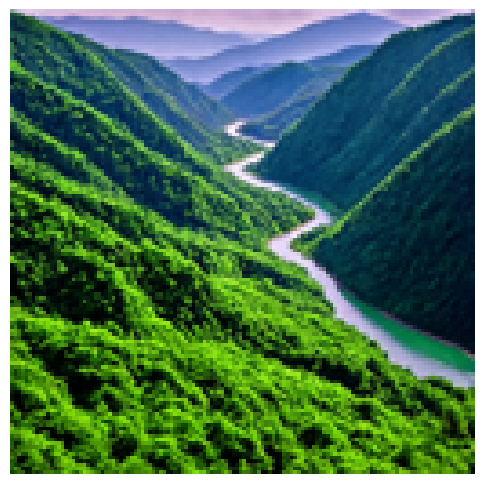

Step: 10000 | Loss: 0.00016571168089285493


In [11]:
if os.path.isdir('progress'):
    rmtree('progress')
os.mkdir('progress')

for step in range(TRAINING_STEPS + 1):
    optimizer.zero_grad()
    generator_input = generator_input_saved

    if REG_NOISE > 0:
        generator_input = generator_input_saved + (noise.normal_() * REG_NOISE)

    output = generator(generator_input)

    loss = objective(output * watermark_var, watermarked_var)
    loss.backward()

    if step % SHOW_STEP == 0:
        output_image = torch_to_np_array(output)
        save_image(output_image, step)
        visualize_sample(output_image, nrow = 1, size_factor = 5)
        print(f'Step: {step} | Loss: {loss.item()}')

    optimizer.step()

In [12]:
output_image = output_image.transpose(1, 2, 0) if output_image.shape == (3, 128, 128) else output_image

# Calculate PSNR
psnr_value = calculate_psnr(np.array(original_image_pil), output_image)
print(f"PSNR between the original and predicted image: {psnr_value:.2f} dB")

PSNR between the original and predicted image: 8.39 dB
